# DA9 Preprocess
06/20/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA9'
subj_format = ['nlx']
subj_site = ['UCD']


## Load raw nlx data 


In [5]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [6]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [7]:
seeg_names = [x.lower() for x in seeg_names] 

In [8]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [9]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}')

Unidentified data type in Photodiode


In [10]:
ch_name

['RIL7',
 'RIL6',
 'LAD1',
 'RFP8',
 'RFP9',
 'LHD8',
 'LHD9',
 'RHD1',
 'LHD2',
 'LHD3',
 'RFP2',
 'RFP3',
 'LFP1',
 'LHD5',
 'LHD4',
 'RHD7',
 'RHD6',
 'LFP7',
 'LFP6',
 'Photodiode',
 'RFP5',
 'RFP4',
 'RIL1',
 'LAD7',
 'LAD6',
 'RHD3',
 'RHD2',
 'LHD1',
 'RFP1',
 'LFP3',
 'LFP2',
 'LFP9',
 'LFP8',
 'RHD9',
 'RHD8',
 'LAD8',
 'RIL4',
 'RIL5',
 'LAD3',
 'LAD2',
 'RIL8',
 'RIL3',
 'RIL2',
 'LAD4',
 'LAD5',
 'LHD6',
 'LHD7',
 'RHD4',
 'RHD5',
 'LFP4',
 'LFP5',
 'RFP6',
 'RFP7']

In [11]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [12]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


In [13]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [14]:
mne_data_resampled[0]

<RawArray | 52 x 7200008 (14400.0 s), ~2.79 GB, data loaded>

In [15]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 53 x 7200008 (14400.0 s), ~2.84 GB, data loaded>

In [16]:
#make channel names lowercase 
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 53 x 7200008 (14400.0 s), ~2.84 GB, data loaded>

## Notch filter line noise

In [17]:

mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    8.0s finished


<RawArray | 53 x 7200008 (14400.0 s), ~2.84 GB, data loaded>

## Examine photodiode

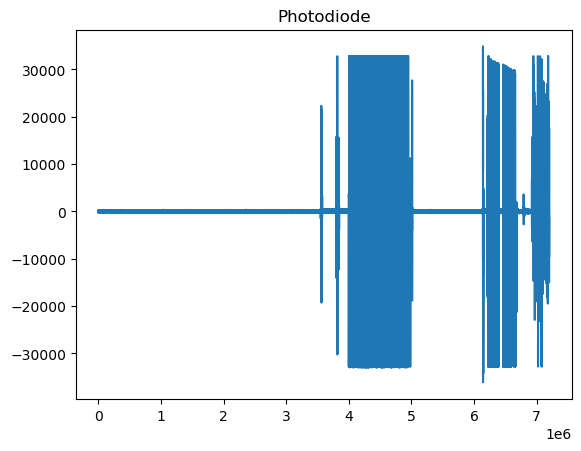

In [18]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('photodiode')
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

Save out photodiode data (after resampling/filtering)

In [32]:
mne_data.save(f'{neural_dir}/DA9/photodiode.fif', picks='photodiode', overwrite=True)

## Add in anat recon info


In [33]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/DA9_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination
0,LAD1,mAmyg_L,-17.471760,10.790956,-9.888621,-14.202810,-3.822049,-19.553816,Gray,Left Amygdala,Amygdala (SF),L ParaHippocampal Gyrus,L Amyg,Left parahippocampal gyrus A,NaN
1,LAD2,mAmyg_L,-22.261112,10.391291,-9.089589,-19.216283,-3.891958,-19.043659,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
2,LAD3,mAmyg_L,-27.449577,10.391291,-8.690073,-24.550816,-3.667518,-19.122501,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
3,LAD4,lAmyg_L,-32.238930,9.991626,-8.290558,-29.505896,-3.881665,-19.126831,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
4,LAD5,Unknown,-37.427395,9.591962,-7.491526,-34.980580,-3.964504,-18.722788,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
5,LAD6,A38l_L,-42.216747,9.192297,-7.092010,-40.067985,-4.078986,-18.697161,Gray,Left PP planum polare,Area Id1,Unknown,L STG,Left superior temporal gyrus A,NaN
6,LAD7,A22r_L,-47.405212,8.792632,-6.292979,-45.629547,-4.036446,-18.194110,Gray,Left Cerebral White Matter,Unknown,L Middle Temporal Gyrus,L STG,Left superior temporal gyrus B,NaN
7,LAD8,aSTS_L,-52.194565,8.792632,-5.493947,-50.795900,-3.681195,-17.772288,Gray,Left STG superior temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior temporal gyrus B,NaN
8,LFP1,A11m_L,-19.068211,44.362791,-1.498790,-13.605498,34.223324,-16.416872,White,Left Cerebral White Matter,Area Fo1,L Rectal Gyrus,L OrG,Unknown,WM
9,LFP2,Unknown,-19.866436,42.364467,2.895883,-15.002357,33.627828,-10.932631,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM


In [44]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['photodiode']


In [38]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)




In [39]:
unmatched_seeg

[]

In [45]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 26 left sEEG and 26 right sEEG electrodes
We have a total of 52 sEEG electrodes


In [43]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'photodiode':'stim'}
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawArray | 53 x 7200008 (14400.0 s), ~2.84 GB, data loaded>

In [46]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 53 x 7200008 (14400.0 s), ~2.84 GB, data loaded>

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [47]:
bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [48]:
bads

['lhd9', 'ril7']

In [49]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [50]:
probe_names

array(['lad', 'lfp', 'lhd', 'rfp', 'rhd', 'ril', 'ulfp', 'ulhd', 'urfp',
       'urhd'], dtype='<U4')

In [51]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [52]:
probe_ch_counts

{'lad': 8,
 'lfp': 9,
 'lhd': 9,
 'rfp': 9,
 'rhd': 9,
 'ril': 8,
 'ulfp': 1,
 'ulhd': 1,
 'urfp': 1,
 'urhd': 1}

<IPython.core.display.Javascript object>


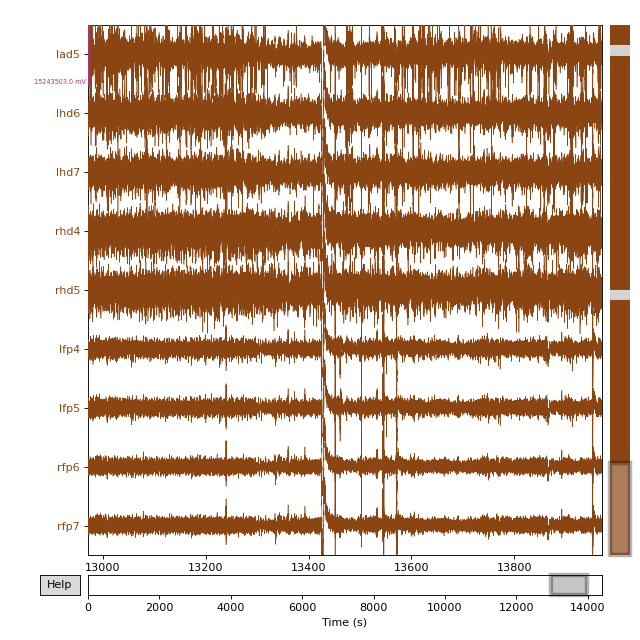

<IPython.core.display.Javascript object>


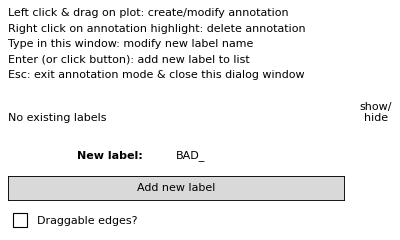

In [60]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=1000, n_channels=9, scalings=mne_data._data.max()/5)
fig.fake_keypress('a')

<IPython.core.display.Javascript object>


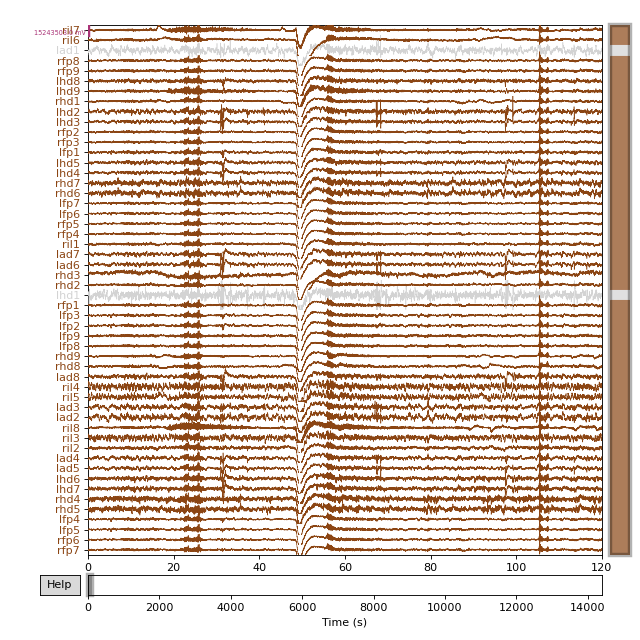

<IPython.core.display.Javascript object>


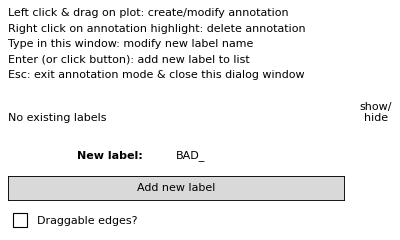

In [61]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=71, scalings=mne_data._data.max()/5)
fig.fake_keypress('a')

In [65]:
##save info in SWB_electrode_info spreadsheet!
bad_ch = ['lad1','lhd1']

In [66]:
mne_data.info['bads'] = bad_ch

In [67]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 2 items (lad1, lhd1)
 ch_names: ril7, ril6, lad1, rfp8, rfp9, lhd8, lhd9, rhd1, lhd2, lhd3, ...
 chs: 52 sEEG
 custom_ref_applied: False
 dig: 52 items (52 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 52
 projs: []
 sfreq: 500.0 Hz
>

### Rereference data to wm electrodes

In [122]:
unmatched_seeg = [] #need this to run script, also need site = 'MSSM' because davis site specificity hasn't been implemented yet 

In [71]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [73]:
oob_channels

['lhd9', 'rhd8', 'rhd9', 'ril6', 'ril7', 'ril8']

In [74]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [75]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lad1', 'lhd1', 'lhd9', 'rhd8', 'rhd9', 'ril6', 'ril7', 'ril8']

In [76]:
mne_data.save(f'{neural_dir}/DA9/lfp_data.fif')

In [77]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [78]:
mne_data_reref

<RawArray | 44 x 7200008 (14400.0 s), ~2.36 GB, data loaded>

In [79]:
mne_data_reref.save(f'{neural_dir}/DA9/wm_ref_ieeg.fif')